# SG Fishing Guide

### Background
Singapore's climate is typical of a tropical region, characterized by abundant rainfall, consistently high temperatures, and elevated humidity throughout the year due to its equatorial location. The climate is influenced by two main monsoon seasons: the Northeast Monsoon from December to early March and the Southwest Monsoon from June to September. Several weather phenomena contribute to heavy rainfall in Singapore, including monsoon surges during the Northeast Monsoon, Sumatra squalls originating west of the country, and afternoon/evening thunderstorms driven by surface heating and sea breeze circulation. Over the past 140 years, Singapore's climate station has been relocated multiple times due to changes in local land use, with the station currently situated at Changi since 1984. Climate metrics such as temperature, humidity, sunshine duration, wind speed, and cloud cover are monitored at Changi and provided as datasets by data.gov.sg for research and analysis purposes.

### Problem Statement
A fishing guide company called SG Fishing Guide,  operating in the eastern waters of Singapore, is exploring the feasibility of a tiered pricing system for their fishing guide services. Instead of having a fixed price for hiring a guide each day throughout the year, the company would like to have a tiered pricing system where customers will be charged lower prices for days when the fishing conditions are less than ideal, and higher prices for days with optimal fishing conditions. This layer of transparency will act as an additional service that would help to build trust among the customers and gain customer loyalty to their brand.

This project aims to analyze the trends and patterns of environmental conditions which affect the quality of fishing and forecast the fishing conditions of future dates for the planning of their tiered pricing system.

### Dataset Sources
'changi.csv': https://www.kaggle.com/datasets/cyanaspect/singapore-weather/data

Contains weather data such as Min, Mean and Max Temperature, Min, Mean and Max Windspeed as well as Daily Rainfall from 2014 - 2020

'combined_output.csv': https://www.kaggle.com/datasets/whitecl0ud/weather-data-of-singapore?select=combined_output.csv

Contains weather data such as Min, Mean and Max Temperature, Min, Mean and Max Windspeed as well as Daily Rainfall from 2020 - 2023

'WetBlubTemperatureHourly.csv': https://beta.data.gov.sg/datasets/d_f222c70a7c00c5a5a9d4ec432d67f6e8/view

Contains hourly Wet Bulb Temperature from 1982 - 2024

### Additional Research
Effects of environmental variables on fish feeding ecology: Implications for the performance of baited fishing gear and stock assessment

Stoner, Allan. (2004). Effects of environmental variables on fish feeding ecology: Implications for the performance of baited fishing gear and stock assessment.
Journal of Fish Biology. 65. 1445 - 1471. 10.1111/j.0022-1112.2004.00593.x. 

### Importing libraries and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from prophet import Prophet
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

col_pal = sns.color_palette("pastel")

c:\Users\faeli\anaconda3\envs\GA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Coding challenges

In [2]:
# Calculating mean value

def mean(numbers):

    total = 0
    for x in numbers:   
        total += x
    return total/len(numbers)

num_list = np.random.randint(0,100, size=20)

mean(num_list)


44.85

In [3]:
# Calculating standard deviation

def stddev(numbers, mean):
    
    sum = 0
    for x in numbers:
        sum += ((x - mean) ** 2)
    return (sum/len(numbers)) ** 0.5

num_list = np.random.randint(0,100, size=20)

stddev(num_list, mean(num_list))

31.452503874890468

### Importing datasets

In [4]:
# importing data from relative path
raw_weather_a = pd.read_csv('changi.csv')
raw_weather_b = pd.read_csv('combined_output.csv')
raw_wbt = pd.read_csv('WetBulbTemperatureHourly.csv')

Cleaning raw_weather_a dataset

In [5]:
raw_weather_a.head()

,Unnamed: 0,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,0,Changi,2014,1,1,0.0,0.0,0.0,0.0,26.7,29.0,24.9,10.0,29.9
1,1,Changi,2014,1,2,0.0,0.0,0.0,0.0,27.4,30.9,25.0,11.9,36.0
2,2,Changi,2014,1,3,0.0,0.0,0.0,0.0,27.1,30.4,24.9,9.7,33.1
3,3,Changi,2014,1,4,0.0,0.0,0.0,0.0,27.1,31.1,24.9,6.4,25.9
4,4,Changi,2014,1,5,18.4,8.6,10.8,15.4,24.8,26.4,23.3,6.8,25.6


In [6]:
# Converting Day, Month, Year into a single Datetime type column, selecting important columns and making Date column the index
raw_weather_a['Date'] = pd.to_datetime(raw_weather_a[['Day','Month','Year']])
raw_weather_a = raw_weather_a[['Date', 'Daily Rainfall Total (mm)', 'Mean Temperature (°C)', 'Mean Wind Speed (km/h)']]
raw_weather_a = raw_weather_a.set_index('Date')

In [7]:
# Checking for data types and continuity of data, we can see that there are several null values in Mean Wind Speed (km/h)
raw_weather_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2557 entries, 2014-01-01 to 2020-12-31
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Daily Rainfall Total (mm)  2557 non-null   float64
 1   Mean Temperature (°C)      2557 non-null   float64
 2   Mean Wind Speed (km/h)     2552 non-null   float64
dtypes: float64(3)
memory usage: 79.9 KB


In [8]:
# Interpolate the missing values by time and check results
raw_weather_a['Mean Wind Speed (km/h)'] = raw_weather_a['Mean Wind Speed (km/h)'].interpolate(method='time')
raw_weather_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2557 entries, 2014-01-01 to 2020-12-31
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Daily Rainfall Total (mm)  2557 non-null   float64
 1   Mean Temperature (°C)      2557 non-null   float64
 2   Mean Wind Speed (km/h)     2557 non-null   float64
dtypes: float64(3)
memory usage: 79.9 KB


Cleaning raw_weather_b dataset

In [9]:
raw_weather_b.head()

,Region,Station,Date,Daily_Rainfall_Total,"Highest Rainfall (mm) (30,60,120) min","Mean,Max,Min Temperature (°C)","Mean,Max Wind Speed (km/h)"
0,North,Admiralty,01-01-2020,0.0,"0.0, 0.0, 0.0","27.5, 31.1, 25.4","22.0, 56.5"
1,North,Admiralty,02-01-2020,0.0,"0.0, 0.0, 0.0","27.4, 30.3, 25.0","20.2, 57.6"
2,North,Admiralty,03-01-2020,0.2,"0.2, 0.2, 0.2","27.5, 30.4, 25.7","22.7, 52.2"
3,North,Admiralty,04-01-2020,7.0,"6.2, 6.8, 7.0","26.7, 30.3, 25.2","20.9, 58.7"
4,North,Admiralty,05-01-2020,0.0,"0.0, 0.0, 0.0","27.6, 31.6, 25.1","22.3, 45.4"


In [10]:
# Checking for available Station Data
raw_weather_b['Station'].unique()

array(['Admiralty', 'Ang Mo Kio', 'Botanic Garden', 'Bukit Panjang',
       'Bukit Timah', 'Buona Vista', 'Changi', 'Choa Chu Kang (Central)',
       'Choa Chu Kang (South)', 'Clementi', 'Dhoby Ghaut',
       'East Coast Parkway', 'Jurong (West)', 'Jurong Island',
       'Jurong Pier', 'Kent Ridge', 'Kranji Reservoir', 'Lim Chu Kang',
       'Lower Peirce Reservoir', 'Macritchie Reservoir', 'Mandai',
       'Marina Barrage', 'Marine Parade', 'Newton', 'Nicoll Highway',
       'Pasir Panjang', 'Pasir Ris (Central)', 'Pasir Ris (West)',
       'Paya Lebar', 'Pulau Ubin', 'Punggol', 'Queenstown', 'Seletar',
       'Semakau Island', 'Sembawang', 'Sentosa Island', 'Serangoon',
       'Simei', 'Somerset (Road)', 'Tai Seng', 'Tanjong Katong', 'Tengah',
       'Toa Payoh', 'Tuas', 'Tuas South', 'Ulu Pandan',
       'Upper Peirce Reservoir', 'Whampoa'], dtype=object)

In [11]:
# Selecting only Changi data, as per raw_weather_a
raw_weather_b = raw_weather_b.loc[raw_weather_b['Station'] == 'Changi']
raw_weather_b.head()

,Region,Station,Date,Daily_Rainfall_Total,"Highest Rainfall (mm) (30,60,120) min","Mean,Max,Min Temperature (°C)","Mean,Max Wind Speed (km/h)"
8580,East,Changi,01-01-2020,0.0,"0.0, 0.0, 0.0","27.9, 31.7, 25.6","12.2, 39.2"
8581,East,Changi,02-01-2020,0.0,"0.0, 0.0, 0.0","27.6, 30.7, 25.4","11.9, 39.6"
8582,East,Changi,03-01-2020,0.0,"0.0, 0.0, 0.0","28.0, 31.9, 26.0","12.6, 43.2"
8583,East,Changi,04-01-2020,0.0,"0.0, 0.0, 0.0","27.6, 31.4, 25.8","12.2, 39.2"
8584,East,Changi,05-01-2020,0.0,"0.0, 0.0, 0.0","27.8, 32.0, 25.1","12.6, 40.7"


In [12]:
# Extract only Mean Temperature from 'Mean,Max,Min Temperature (°C)' column and create 'Mean Temperature (°C)' column 
raw_weather_b['Mean Temperature (°C)'] = raw_weather_b['Mean,Max,Min Temperature (°C)'].str.split(',').str[0]

# Extract only Mean Wind Speed from 'Mean,Max Windspeed (°C)' column and create 'Mean Wind Speed (km/h)' column
raw_weather_b['Mean Wind Speed (km/h)'] = raw_weather_b['Mean,Max Wind Speed (km/h)'].str.split(',').str[0]

raw_weather_b.head()

,Region,Station,Date,Daily_Rainfall_Total,"Highest Rainfall (mm) (30,60,120) min","Mean,Max,Min Temperature (°C)","Mean,Max Wind Speed (km/h)",Mean Temperature (°C),Mean Wind Speed (km/h)
8580,East,Changi,01-01-2020,0.0,"0.0, 0.0, 0.0","27.9, 31.7, 25.6","12.2, 39.2",27.9,12.2
8581,East,Changi,02-01-2020,0.0,"0.0, 0.0, 0.0","27.6, 30.7, 25.4","11.9, 39.6",27.6,11.9
8582,East,Changi,03-01-2020,0.0,"0.0, 0.0, 0.0","28.0, 31.9, 26.0","12.6, 43.2",28.0,12.6
8583,East,Changi,04-01-2020,0.0,"0.0, 0.0, 0.0","27.6, 31.4, 25.8","12.2, 39.2",27.6,12.2
8584,East,Changi,05-01-2020,0.0,"0.0, 0.0, 0.0","27.8, 32.0, 25.1","12.6, 40.7",27.8,12.6


In [13]:
# Selecting only relevant columns for our analyses and checking the datatypes
raw_weather_b = raw_weather_b[['Date', 'Daily_Rainfall_Total', 'Mean Temperature (°C)', 'Mean Wind Speed (km/h)']]

raw_weather_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1430 entries, 8580 to 10009
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Date                    1430 non-null   object
 1   Daily_Rainfall_Total    1430 non-null   object
 2   Mean Temperature (°C)   1430 non-null   object
 3   Mean Wind Speed (km/h)  1430 non-null   object
dtypes: object(4)
memory usage: 55.9+ KB


In [14]:
# Converting Date column into a Datetime type, selecting important columns and make Date column the index
raw_weather_b['Date'] = pd.to_datetime(raw_weather_b['Date'], format = '%d-%m-%Y')
raw_weather_b = raw_weather_b.set_index('Date')

# Renaming Daily_Rainfall_Total column to 'Daily Rainfall Total (mm)', as per raw_weather_a
raw_weather_b.rename(columns = {'Daily_Rainfall_Total' : 'Daily Rainfall Total (mm)'}, inplace = True)

raw_weather_b.head()

,Daily Rainfall Total (mm),Mean Temperature (°C),Mean Wind Speed (km/h)
Date,,,
2020-01-01,0.0,27.9,12.2
2020-01-02,0.0,27.6,11.9
2020-01-03,0.0,28.0,12.6
2020-01-04,0.0,27.6,12.2
2020-01-05,0.0,27.8,12.6


In [15]:
# Converting objects to float datatype
convert_obj_to_flt = ['Daily Rainfall Total (mm)', 'Mean Temperature (°C)', 'Mean Wind Speed (km/h)']

#raw_weather_b[convert_obj_to_flt] = raw_weather_b[convert_obj_to_flt].apply(pd.to_numeric)
# Found that there is a ValueError: Unable to parse string '-'. Inspected values and found '-' in 'Mean Wind Speed (km/h)' column
#print(raw_weather_b['Daily Rainfall Total (mm)'].unique())
#print(raw_weather_b['Mean Temperature (°C)'].unique())
#print(raw_weather_b['Mean Wind Speed (km/h)'].unique())

# Replace '-' values with None and continue converting objects to float
raw_weather_b['Mean Wind Speed (km/h)'] = raw_weather_b['Mean Wind Speed (km/h)'].map(lambda x: None if x == '-' else x)
raw_weather_b[convert_obj_to_flt] = raw_weather_b[convert_obj_to_flt].apply(pd.to_numeric)
raw_weather_b.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1430 entries, 2020-01-01 to 2023-11-30
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Daily Rainfall Total (mm)  1430 non-null   float64
 1   Mean Temperature (°C)      1430 non-null   float64
 2   Mean Wind Speed (km/h)     1428 non-null   float64
dtypes: float64(3)
memory usage: 44.7 KB


In [16]:
# Confirmed that data types have been changed, however there are 2 null values in Mean Wind Speed (km/h)
# Interpolate the missing values by time
raw_weather_b['Mean Wind Speed (km/h)'] = raw_weather_b['Mean Wind Speed (km/h)'].interpolate(method='time')
raw_weather_b.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1430 entries, 2020-01-01 to 2023-11-30
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Daily Rainfall Total (mm)  1430 non-null   float64
 1   Mean Temperature (°C)      1430 non-null   float64
 2   Mean Wind Speed (km/h)     1430 non-null   float64
dtypes: float64(3)
memory usage: 44.7 KB


Cleaning raw_wbt dataset

In [17]:
print(raw_wbt.head())
print(raw_wbt.tail())
raw_wbt.info()

     wbt_date  wbt_time  wet_bulb_temperature
0  1982-01-01         1                  24.7
1  1982-01-01         2                  24.5
2  1982-01-01         3                  24.3
3  1982-01-01         4                  24.2
4  1982-01-01         5                  24.2
          wbt_date  wbt_time  wet_bulb_temperature
370339  2024-03-31        20                  25.4
370340  2024-03-31        21                  25.6
370341  2024-03-31        22                  25.6
370342  2024-03-31        23                  25.6
370343  2024-03-31        24                  25.6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370344 entries, 0 to 370343
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   wbt_date              370344 non-null  object 
 1   wbt_time              370344 non-null  int64  
 2   wet_bulb_temperature  370344 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory u

In [18]:
# Convert wbt_date to Datetime format, relabel it as Date and select only relevant Dates to reduce memory usage
raw_wbt['Date'] = pd.to_datetime(raw_wbt['wbt_date'])
raw_wbt = raw_wbt.loc[raw_wbt['Date'] > '2013-12-31']
raw_wbt = raw_wbt.loc[raw_wbt['Date'] < '2023-12-01']

In [19]:
# Check for datatypes and missing values: Correct datatypes and no missing values observed
raw_wbt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86904 entries, 280512 to 367415
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   wbt_date              86904 non-null  object        
 1   wbt_time              86904 non-null  int64         
 2   wet_bulb_temperature  86904 non-null  float64       
 3   Date                  86904 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.3+ MB


In [20]:
# As the data is collected hourly, we will use groupby() to calculate the daily mean and rename it 'Wet Bulb Temperature (°C)'
# We will also create a new dataframe over raw_wbt with 'Date' as the index and 'Wet Bulb Temperature (°C)' as a column
raw_wbt.rename(columns = {'wet_bulb_temperature' : 'Mean Wet Bulb Temperature (°C)'}, inplace = True)
raw_wbt = pd.DataFrame(raw_wbt.groupby('Date')['Mean Wet Bulb Temperature (°C)'].mean())
# Rounding the value of the means to 1 decimal place for cleaner viewing
raw_wbt['Mean Wet Bulb Temperature (°C)'] = raw_wbt['Mean Wet Bulb Temperature (°C)'].map(lambda x: round(x,1))
raw_wbt.head()

,Mean Wet Bulb Temperature (°C)
Date,
2014-01-01,24.8
2014-01-02,25.1
2014-01-03,25.0
2014-01-04,24.6
2014-01-05,24.0


Combining all 3 datasets into 1 dataframe

In [21]:
# Merge raw_weather_a and raw_weather_b datasets into 1 dataframe 'weather', but since there are overlapping dates, to use combine_first() instead
weather = raw_weather_a.combine_first(raw_weather_b)
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3621 entries, 2014-01-01 to 2023-11-30
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Daily Rainfall Total (mm)  3621 non-null   float64
 1   Mean Temperature (°C)      3621 non-null   float64
 2   Mean Wind Speed (km/h)     3621 non-null   float64
dtypes: float64(3)
memory usage: 113.2 KB


In [22]:
# Merge raw_wbt dataset into weather dataset and add 'Dry and Wet Temp Diff (°C)' column
weather  = pd.merge(weather, raw_wbt, how = 'left', on = 'Date')
weather['Dry and Wet Temp Diff (°C)'] = weather['Mean Temperature (°C)'] - weather['Mean Wet Bulb Temperature (°C)']
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3621 entries, 2014-01-01 to 2023-11-30
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Daily Rainfall Total (mm)       3621 non-null   float64
 1   Mean Temperature (°C)           3621 non-null   float64
 2   Mean Wind Speed (km/h)          3621 non-null   float64
 3   Mean Wet Bulb Temperature (°C)  3621 non-null   float64
 4   Dry and Wet Temp Diff (°C)      3621 non-null   float64
dtypes: float64(5)
memory usage: 169.7 KB


### Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|Station|string|changi|Location of measurement| 
|Year|integer|changi|Year of measurement| 
|Month|integer|changi|Month of measurement| 
|Day|integer|changi|Day of measurement| 
|Daily Rainfall Total (mm)|float|changi|Total rainfall in mm for the day| 
|Highest 30 min Rainfall (mm)|float|changi|Highest rainfall recorded in 30min intervals| 
|Highest 60 min Rainfall (mm)|float|changi|Highest rainfall recorded in 60min intervals| 
|Highest 120 min Rainfall (mm)|float|changi|Highest rainfall recorded in 120min intervals| 
|Mean Temperature (°C)|float|changi|Mean temperature in °C for the day| 
|Maximum Temperature (°C)|float|changi|Max temperature in °C for the day| 
|Minimum Temperature (°C)|float|changi|Min temperature in °C for the day| 
|Mean Wind Speed (km/h) |float|changi|Mean wind speed in km/h for the day| 
|Max Wind Speed (km/h)  |float|changi|Max wind speed in km/h for the day| 
|Region|string|combined_output|Region of measurement| 
|Station|string|combined_output|Location of measurement| 
|Date|string|combined_output|Date of measurement| 
|Daily_Rainfall_Total|string|combined_output|Total rainfall in mm for the day| 
|Highest Rainfall (mm) (30,60,120) min|string|combined_output|Highest rainfall recorded in 30, 60 and 120min intervals|
|Mean,Max,Min Temperature (°C)|string|combined_output|Mean, Max and Min temperature in °C for the day|
|Mean,Max Wind Speed (km/h)|string|combined_output|Mean and Max wind speed in km/h for the day|
|wbt_date|string|WetBulbTemperatureHourly|Date of measurement| 
|wbt_time|integer|WetBulbTemperatureHourly|Hour of the day of measurement| 
|wet_bulb_temperature|float|WetBulbTemperatureHourly|Hourly reading of Wet bulb temperature in °C| 



### Exploratory Data Analysis & Visualizations

In [23]:
# No rain to Light rain is considered to be < 0.25inch (6.35mm) while Medium to heavy rain is considered to be >= 0.25inch (6.35mm)
# As our analysis will only consider Medium to heavy rain as a factor that will affect the temperature of water, we will categorize the rain occurrence to
# 0 for No rain to Light rain, and 1 for Medium to Heavy rain and label it 'Rain Factor'

weather['Rain Factor'] = [int(0) if x < 6.35 else int(1) for x in weather['Daily Rainfall Total (mm)']]
weather.head(10)

,Daily Rainfall Total (mm),Mean Temperature (°C),Mean Wind Speed (km/h),Mean Wet Bulb Temperature (°C),Dry and Wet Temp Diff (°C),Rain Factor
Date,,,,,,
2014-01-01,0.0,26.7,10.0,24.8,1.9,0
2014-01-02,0.0,27.4,11.9,25.1,2.3,0
2014-01-03,0.0,27.1,9.7,25.0,2.1,0
2014-01-04,0.0,27.1,6.4,24.6,2.5,0
2014-01-05,18.4,24.8,6.8,24.0,0.8,1
2014-01-06,31.2,25.3,6.1,24.7,0.6,1
2014-01-07,0.0,26.7,8.1,24.5,2.2,0
2014-01-08,0.0,27.1,9.0,24.2,2.9,0
2014-01-09,2.0,25.9,5.1,24.2,1.7,0


In [24]:
# Summary Statistics

weather.describe()

,Daily Rainfall Total (mm),Mean Temperature (°C),Mean Wind Speed (km/h),Mean Wet Bulb Temperature (°C),Dry and Wet Temp Diff (°C),Rain Factor
count,3621.000000,3621.000000,3621.000000,3621.000000,3621.000000,3621.000000
mean,5.233637,28.066998,8.996672,25.068489,2.998509,0.204916
std,12.576310,1.124045,3.105518,0.743438,0.827265,0.403696
min,0.000000,23.000000,0.400000,21.800000,0.100000,0.000000
25%,0.000000,27.300000,6.500000,24.600000,2.400000,0.000000
50%,0.000000,28.100000,8.300000,25.100000,3.000000,0.000000
75%,4.000000,28.900000,11.200000,25.600000,3.600000,0.000000
max,210.600000,30.700000,22.400000,27.700000,6.700000,1.000000


In [25]:
# Using dictionary comprehension to apply earlier created stddev() function to all columns 

sd = {col: stddev(weather[col], mean(weather[col])) for col in weather.columns}
sd

{'Daily Rainfall Total (mm)': 12.574573168165447,
 'Mean Temperature (°C)': 1.123889647392361,
 'Mean Wind Speed (km/h)': 3.105089647293143,
 'Mean Wet Bulb Temperature (°C)': 0.7433354145210985,
 'Dry and Wet Temp Diff (°C)': 0.8271510995253581,
 'Rain Factor': 0.40364005832999517}

Bar Chart of past three years of Rain Factors to find pockets of periods where the rain will not affect fishing conditions

C:\Users\faeli\AppData\Local\Temp\ipykernel_5244\2606717106.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([1, 3, 5, 7, 9, 11])
C:\Users\faeli\AppData\Local\Temp\ipykernel_5244\2606717106.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([1, 3, 5, 7, 9, 11])
C:\Users\faeli\AppData\Local\Temp\ipykernel_5244\2606717106.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels([1, 3, 5, 7, 9, 11])


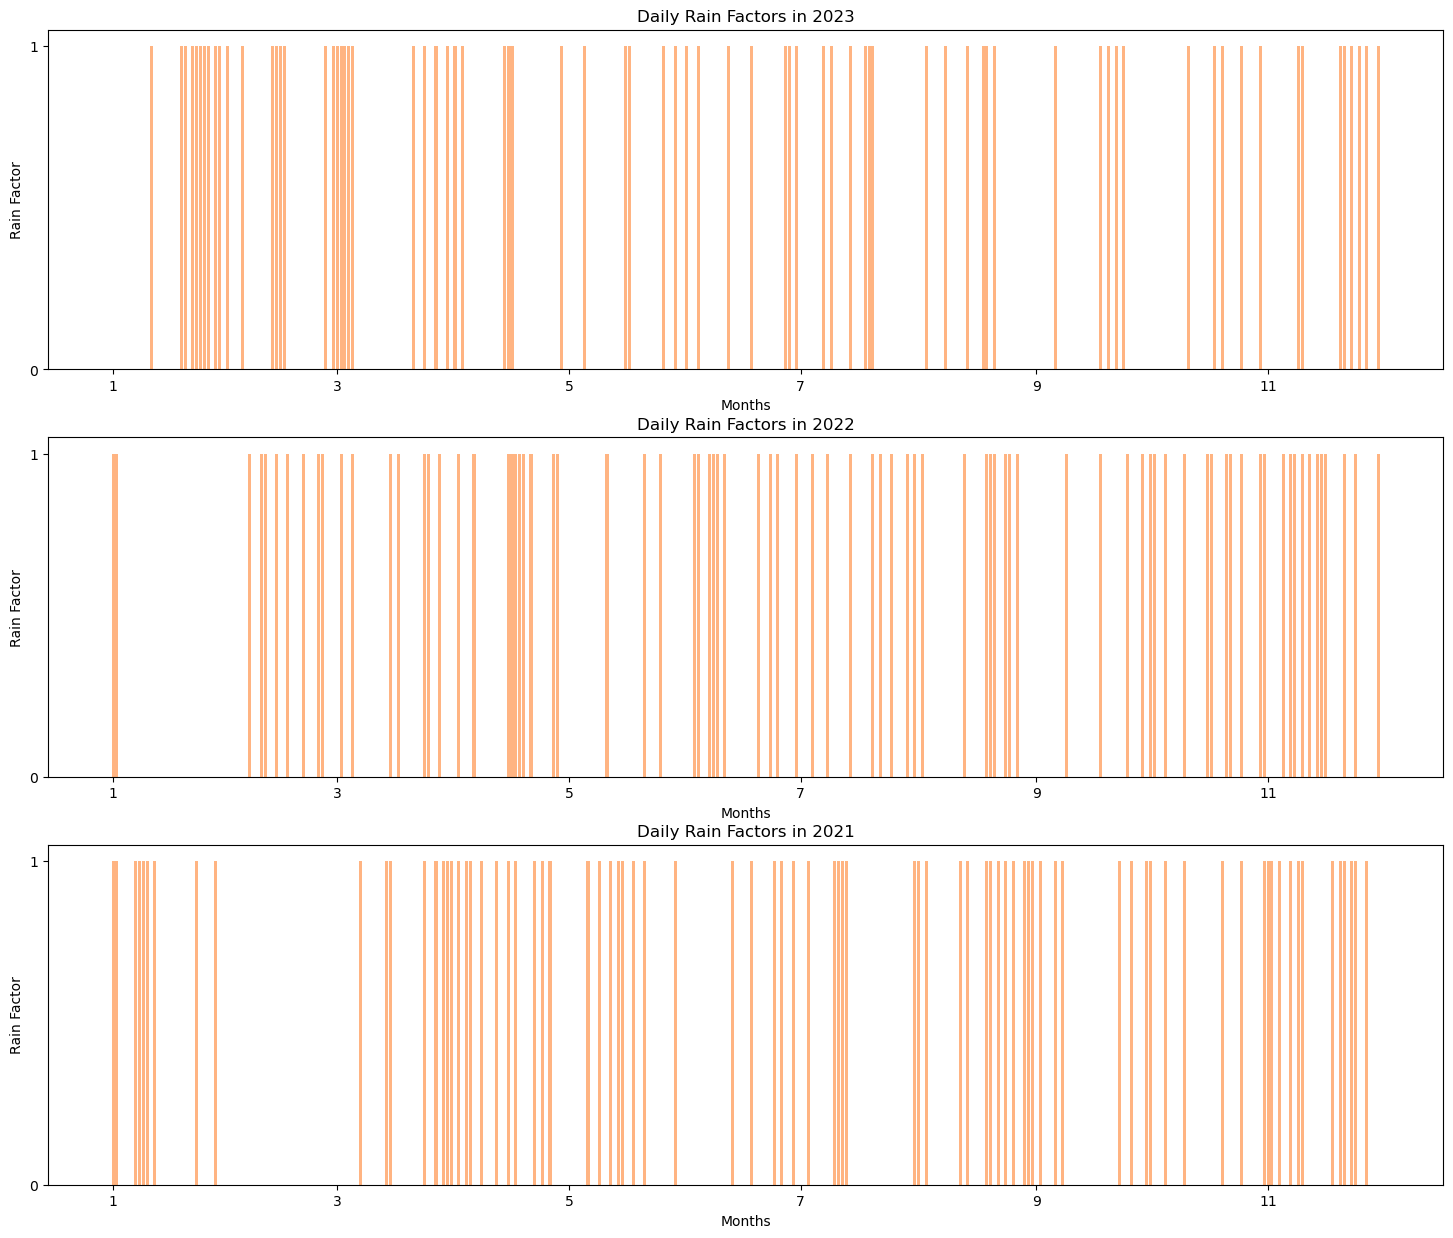

In [26]:
# Bar Charts of past three years of Rain Factors to Dates

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (18,15))

weather2023 = weather['2023-01-01':'2023-11-30']
weather2022 = weather['2022-01-01':'2022-11-30']
weather2021 = weather['2021-01-01':'2021-11-30']

ax1.bar(weather2023.index, weather2023['Rain Factor'], color=col_pal[1])
ax1.yaxis.set_ticks((0,1))
ax1.set_xticklabels([1, 3, 5, 7, 9, 11])
ax1.set_title('Daily Rain Factors in 2023')
ax1.set_xlabel('Months')
ax1.set_ylabel('Rain Factor')

ax2.bar(weather2022.index, weather2022['Rain Factor'], color=col_pal[1])
ax2.yaxis.set_ticks((0,1))
ax2.set_xticklabels([1, 3, 5, 7, 9, 11])
ax2.set_title('Daily Rain Factors in 2022')
ax2.set_xlabel('Months')
ax2.set_ylabel('Rain Factor')

ax3.bar(weather2021.index, weather2021['Rain Factor'], color=col_pal[1])
ax3.yaxis.set_ticks((0,1))
ax3.set_xticklabels([1, 3, 5, 7, 9, 11])
ax3.set_title('Daily Rain Factors in 2021')
ax3.set_xlabel('Months')
ax3.set_ylabel('Rain Factor')

plt.show()


Box plot diagram of past three years' Average Temperature by month

C:\Users\faeli\AppData\Local\Temp\ipykernel_5244\3996416692.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = temp_boxplot, x = 'Month', y = 'Mean Temperature (°C)', palette='pastel')


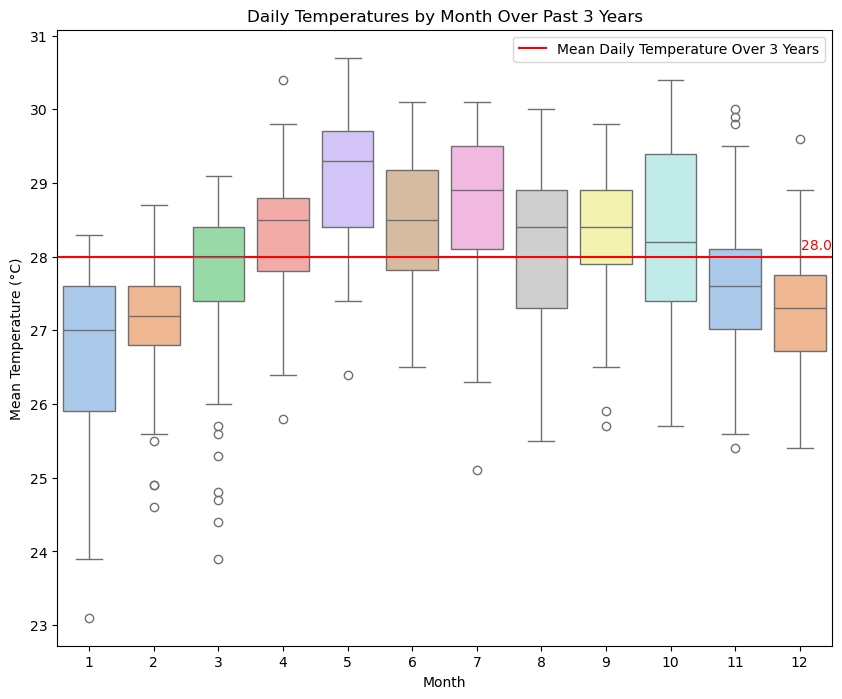

In [27]:
temp_boxplot = pd.DataFrame(weather['Mean Temperature (°C)'])
temp_boxplot['Month'] = temp_boxplot.index.month
temp_boxplot = temp_boxplot.loc[temp_boxplot.index > '2020-12-31']
mean_temp = temp_boxplot['Mean Temperature (°C)'].mean()
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = temp_boxplot, x = 'Month', y = 'Mean Temperature (°C)', palette='pastel')
ax.axhline(y=mean_temp, color = 'red', label='Mean Daily Temperature Over 3 Years')
ax.set_title('Daily Temperatures by Month Over Past 3 Years')
ax.annotate(round(mean_temp,1), xy=(11, mean_temp), xytext=(1, 5), textcoords='offset points', color='red')
ax.legend()


Line plot of past three years' Average Wind Speeds by month

C:\Users\faeli\AppData\Local\Temp\ipykernel_5244\3598386562.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = wind_plot, x = 'Month', y = 'Mean Wind Speed (km/h)', palette='pastel')


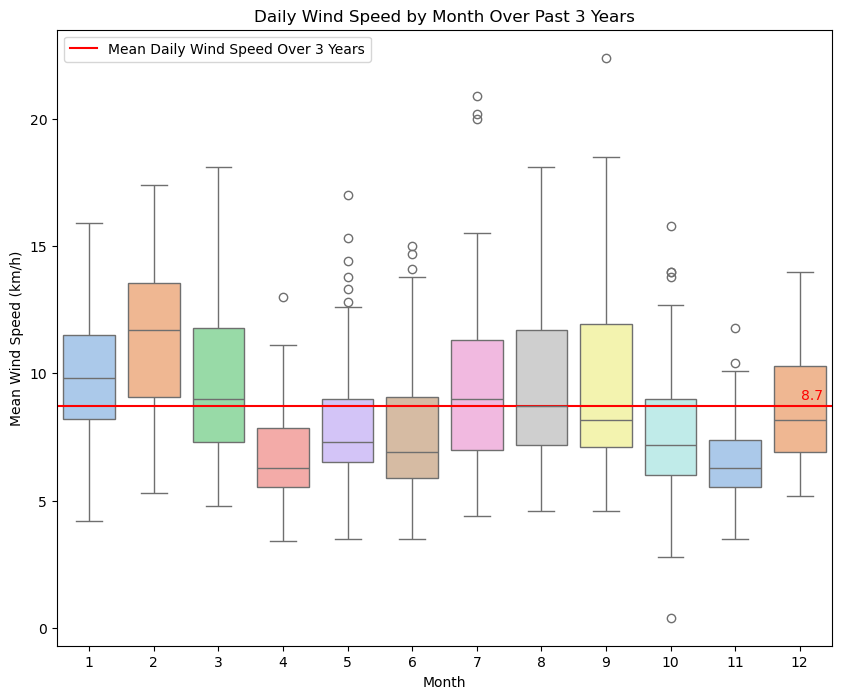

In [28]:
wind_plot = pd.DataFrame(weather['Mean Wind Speed (km/h)'])
wind_plot['Month'] = wind_plot.index.month
wind_plot = wind_plot.loc[wind_plot.index > '2020-12-31']
mean_wind = wind_plot['Mean Wind Speed (km/h)'].mean()
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = wind_plot, x = 'Month', y = 'Mean Wind Speed (km/h)', palette='pastel')
ax.axhline(y=mean_wind, color = 'red', label='Mean Daily Wind Speed Over 3 Years')
ax.set_title('Daily Wind Speed by Month Over Past 3 Years')
ax.annotate(round(mean_wind,1), xy=(11, mean_wind), xytext=(1, 5), textcoords='offset points', color='red')
ax.legend()

Dry & Wet Bulb Temperature and Wind Speed Plots

Text(0.5, 1.0, 'Daily Mean Wind Speed')

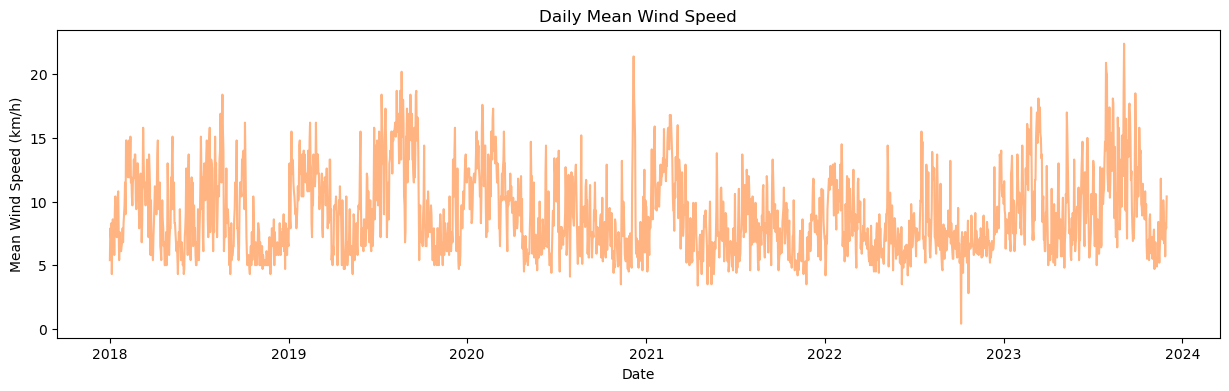

In [29]:
fig, ax = plt.subplots(figsize=(15,4))
windspeed = weather.loc[weather.index > '2017-12-31']
sns.lineplot(data=windspeed['Mean Wind Speed (km/h)'], color=col_pal[1])
ax.set_title('Daily Mean Wind Speed')

Text(0.5, 1.0, 'Daily Mean Temperature')

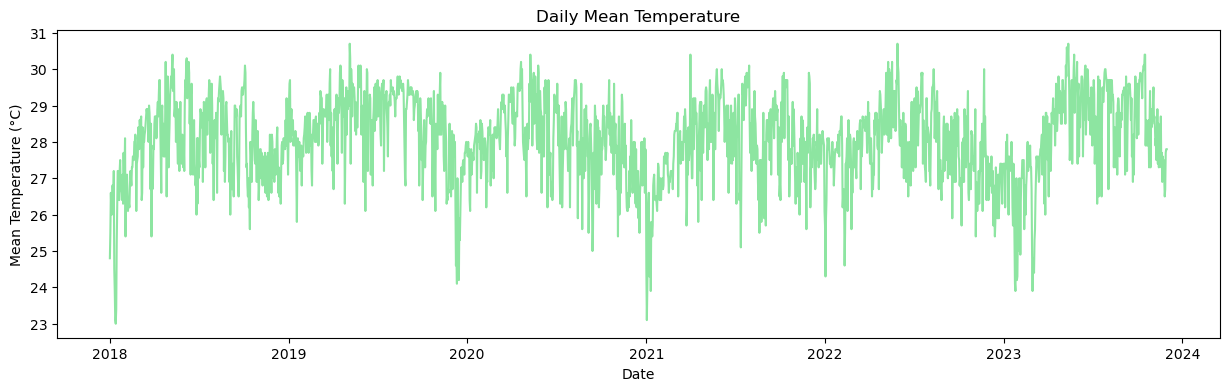

In [30]:
fig, ax = plt.subplots(figsize=(15,4))
drytemp = weather.loc[weather.index > '2017-12-31']
sns.lineplot(data=drytemp['Mean Temperature (°C)'], color=col_pal[2])
ax.set_title('Daily Mean Temperature')

Text(0.5, 1.0, 'Daily Mean Wet Bulb Temperature')

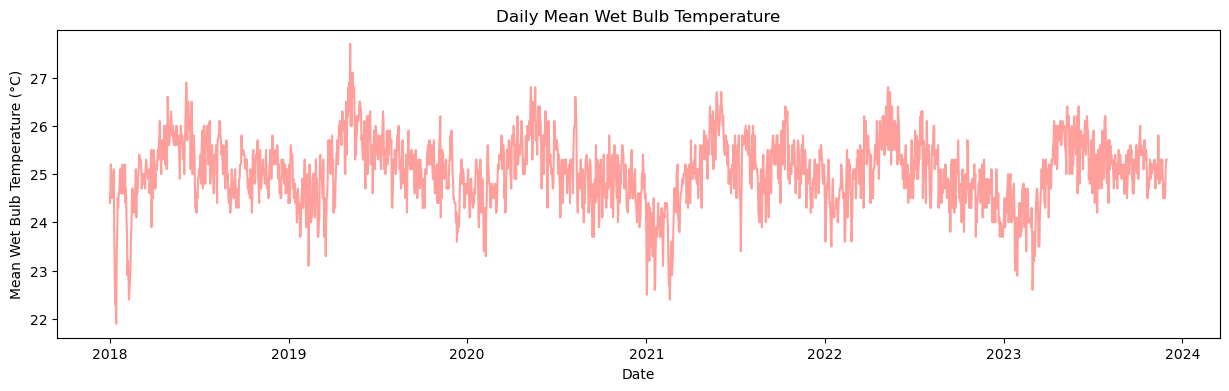

In [31]:
fig, ax = plt.subplots(figsize=(15,4))
wettemp = weather.loc[weather.index > '2017-12-31']
sns.lineplot(data=wettemp['Mean Wet Bulb Temperature (°C)'], color=col_pal[3])
ax.set_title('Daily Mean Wet Bulb Temperature')

Check for data stationarity using ADF and KPSS Test

In [32]:
# Creating ADF Test Function adftest()

def adftest(TSdata):
    test = adfuller(TSdata)
    if test[1] <= 0.05:
        print('p-value: <= 0.05')
    else:
        print('p-value: > 0.05')
    if test[1] <= 0.05:
        print("Reject null hypothesis - Time series is stationary")
    else:
        print("Fail to reject null hypothesis - Time series is non-stationary")

In [33]:
# Creating KPSS Test Function kpsstest()

def kpsstest(TSdata):
    test = kpss(TSdata)
    if test[1] > 0.05:
        print('p-value: > 0.05')
    else:
        print('p-value: <= 0.05')
    if test[1] <= 0.05:
        print("Reject null hypothesis - Time series is non-stationary")
    else:
        print("Fail to reject null hypothesis - Time series is stationary")

In [34]:
# Perform ADF Test for Temperature, Wet Bulb Temperature and Wind Speed

print('Daily Mean Temperature Test')
adftest(weather['Mean Temperature (°C)'])
print('Daily Mean Wet Bulb Temperature Test')
adftest(weather['Mean Wet Bulb Temperature (°C)'])
print('Daily Mean Wind Speed Test')
adftest(weather['Mean Wind Speed (km/h)'])
print('Dry and Wet Temp Diff Test')
adftest(weather['Dry and Wet Temp Diff (°C)'])

Daily Mean Temperature Test
p-value: <= 0.05
Reject null hypothesis - Time series is stationary
Daily Mean Wet Bulb Temperature Test
p-value: <= 0.05
Reject null hypothesis - Time series is stationary
Daily Mean Wind Speed Test
p-value: <= 0.05
Reject null hypothesis - Time series is stationary
Dry and Wet Temp Diff Test
p-value: <= 0.05
Reject null hypothesis - Time series is stationary


In [35]:
# Perform KPSS Test for Temperature, Wet Bulb Temperature and Wind Speed

print('Daily Mean Temperature Test')
kpsstest(weather['Mean Temperature (°C)'])
print('Daily Mean Wet Bulb Temperature Test')
kpsstest(weather['Mean Wet Bulb Temperature (°C)'])
print('Daily Mean Wind Speed Test')
kpsstest(weather['Mean Wind Speed (km/h)'])
print('Dry and Wet Temp Diff Test')
kpsstest(weather['Dry and Wet Temp Diff (°C)'])

Daily Mean Temperature Test
p-value: > 0.05
Fail to reject null hypothesis - Time series is stationary
Daily Mean Wet Bulb Temperature Test
p-value: > 0.05
Fail to reject null hypothesis - Time series is stationary
Daily Mean Wind Speed Test
p-value: > 0.05
Fail to reject null hypothesis - Time series is stationary
Dry and Wet Temp Diff Test
p-value: > 0.05
Fail to reject null hypothesis - Time series is stationary


C:\Users\faeli\AppData\Local\Temp\ipykernel_5244\2021178.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  test = kpss(TSdata)
C:\Users\faeli\AppData\Local\Temp\ipykernel_5244\2021178.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  test = kpss(TSdata)
C:\Users\faeli\AppData\Local\Temp\ipykernel_5244\2021178.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  test = kpss(TSdata)
C:\Users\faeli\AppData\Local\Temp\ipykernel_5244\2021178.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  test = kpss(

With both visual inspection and statistical tests confirming the stationarity of the datas, we will use the Prophet model to forecast the values for the next 6 months.

In [36]:
def prophetxgb_predict(data, col_name):
    
    # Random Seed for reproducibility
    np.random.seed(666)

    # Preparing data for Prophet model inputs (Using 4 Years historical data for forecasting)
    timeseries_data = data[col_name]
    timeseries_data = timeseries_data.loc[timeseries_data.index > '2019-12-31']
    timeseries_data = timeseries_data.reset_index()
    timeseries_data = timeseries_data.rename(columns = {'Date' : 'ds', col_name : 'y'})
    # Adding noise to data
    timeseries_data['y_noise'] = timeseries_data['y'] + np.random.normal(scale=0.9, size=len(timeseries_data))
    
    # Using Prophet to make initial forecast of 180 days and create features for all data
    model = Prophet(changepoint_prior_scale=0.9, seasonality_mode='multiplicative')
    model.fit(timeseries_data)
    future = model.make_future_dataframe(periods=180)
    forecast = model.predict(future)
    forecast['day'] = forecast['ds'].dt.day_of_year
    forecast['month'] = forecast['ds'].dt.month
    
    raw_prophet_forecast = forecast # Returned for future use of features created by Prophet
    
    # Using features created by Prophet for the historical data, create X_train
    # Using actual historical target data, create y_train
    X_train = forecast[['yhat_lower', 'yhat_upper', 'day', 'month']].iloc[:-180]
    y_train = timeseries_data['y']

    # Using features created by Prophet for forcasted data, create X
    X = forecast[['yhat_lower', 'yhat_upper', 'day', 'month']].iloc[-180:]

    # Ensemble Prophet with XGBoost and train XGBRegressor Model using features created by Prophet
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X_train,y_train)

    # Creating new dataframe with Prophet's predicted data and select only 'ds' and 'yhat' columns
    ensemble_forecast = forecast.iloc[-180:]
    ensemble_forecast = ensemble_forecast.loc[:,['ds','yhat']]

    # Using XGB model to predict future data, and take the averages of XGB predicted values and Phophet's predicted values as final predicted value
    ensemble_forecast['xgb forecast'] = xgb_model.predict(X)
    ensemble_forecast['final pred'] = (ensemble_forecast['xgb forecast'] + ensemble_forecast['yhat']) / 2

    # Selecting only target column and index the predictions with dates
    ensemble_forecast = ensemble_forecast.loc[:,['ds','final pred']]
    ensemble_forecast = ensemble_forecast.rename(columns = {'ds' : 'Date', 'final pred' : f'Forecasted {col_name}'})
    ensemble_forecast.set_index('Date', inplace = True)

    return raw_prophet_forecast, ensemble_forecast


Data to be forecasted

In [37]:
raw_ftemp, forecasted_temp = prophetxgb_predict(weather, 'Mean Temperature (°C)')
raw_fwbtemp, forecasted_wbtemp = prophetxgb_predict(weather, 'Mean Wet Bulb Temperature (°C)')
raw_fws, forecasted_windspeed = prophetxgb_predict(weather, 'Mean Wind Speed (km/h)')
raw_ftempwbtempdiff, forecasted_temp_wbtemp_diff = prophetxgb_predict(weather, 'Dry and Wet Temp Diff (°C)')

forecasted_weather = forecasted_temp.join(forecasted_wbtemp, how='left')
forecasted_weather = forecasted_weather.join(forecasted_windspeed, how='left')
forecasted_weather = forecasted_weather.join(forecasted_temp_wbtemp_diff, how='left')
forecasted_weather.tail()

22:20:42 - cmdstanpy - INFO - Chain [1] start processing
22:20:43 - cmdstanpy - INFO - Chain [1] done processing
22:20:43 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing
22:20:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing
22:20:45 - cmdstanpy - INFO - Chain [1] start processing
22:20:45 - cmdstanpy - INFO - Chain [1] done processing


,Forecasted Mean Temperature (°C),Forecasted Mean Wet Bulb Temperature (°C),Forecasted Mean Wind Speed (km/h),Forecasted Dry and Wet Temp Diff (°C)
Date,,,,
2024-05-24,30.421009,26.489827,10.523897,3.966081
2024-05-25,30.512096,26.324135,8.870920,3.879201
2024-05-26,30.583865,26.317670,8.293031,3.867721
2024-05-27,30.343913,26.275028,7.872832,3.910008
2024-05-28,30.456404,26.253896,8.101615,3.925100


<Axes: xlabel='Date'>

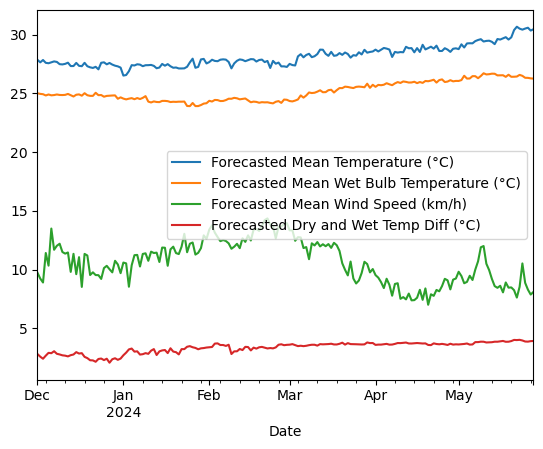

In [38]:
forecasted_weather.plot()

Prepare data for training and predicting using selected Prophet's created features

In [39]:
raw_ftemp = raw_ftemp.loc[:,['yhat_lower', 'day', 'month']]
raw1 = raw_ftemp.rename(columns={'yhat_lower':'yhat_lower_ftemp'})

raw_fwbtemp = raw_fwbtemp.loc[:,['yhat_upper']]
raw2 =raw_fwbtemp.rename(columns={'yhat_upper':'yhat_upper_fwbtemp'})

raw_fws = raw_fws.loc[:,['trend', 'yhat_lower', 'yhat_upper']]
raw3 =raw_fws.rename(columns={'trend':'trend_fws', 'yhat_lower':'yhat_lower_fws', 'yhat_upper':'yhat_upper_fws'})

raw_ftempwbtempdiff = raw_ftempwbtempdiff.loc[:,['yhat_lower']]
raw4 =raw_ftempwbtempdiff.rename(columns={'yhat_lower':'yhat_lower_ftempwbtempdiff'})

combined_raw_forecast = raw1.join(raw2, how='left')
combined_raw_forecast = combined_raw_forecast.join(raw3, how='left')
combined_raw_forecast = combined_raw_forecast.join(raw4, how='left')
combined_raw_forecast['lowerftemp_upperfwb_temp_diff'] = combined_raw_forecast['yhat_lower_ftemp'] - combined_raw_forecast['yhat_upper_fwbtemp']

Using XGBClassifier and forecasted_weather, predict the rain factor for the predicted dates

In [40]:
rain_model = xgb.XGBClassifier(device='gpu', n_estimators = 100, max_depth = 5, learning_rate = 0.1)

# Adding and selecting features (created by Prophet) and target for prediction
combined_raw_forecast_training = combined_raw_forecast.iloc[:-180]
combined_raw_forecast_predict = combined_raw_forecast.iloc[-180:]
features = ['day', 'month', 'yhat_lower_fws', 'lowerftemp_upperfwb_temp_diff']
target = ['Rain Factor']
weather = weather.loc[weather.index > '2019-12-31']

# Train/Test Split 
X_train, X_val, y_train, y_val = train_test_split(combined_raw_forecast_training[features], weather[target], test_size=0.2,  stratify=weather[target], random_state=0)

Use GridSearchCV to find best parameters

In [41]:
# Using Gridsearch CV to find best set of hyperparameters
GS_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

GS = GridSearchCV(estimator = rain_model, param_grid = GS_params, cv = 4, scoring = 'accuracy', verbose = 3)
GS.fit(X_train, y_train)


Fitting 4 folds for each of 27 candidates, totalling 108 fits


c:\Users\faeli\anaconda3\envs\GA\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:20:47] WARNING: D:\bld\xgboost-split_1712073657315\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 1/4] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.752 total time=   0.3s
[CV 2/4] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.759 total time=   0.0s
[CV 3/4] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.766 total time=   0.0s
[CV 4/4] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.748 total time=   0.0s
[CV 1/4] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.759 total time=   0.1s
[CV 2/4] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.752 total time=   0.1s
[CV 3/4] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.748 total time=   0.1s
[CV 4/4] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.745 total time=   0.1s
[CV 1/4] END learning_rate=0.1, max_depth=3, n_estimators=150;, score=0.741 total time=   0.1s
[CV 2/4] END learning_rate=0.1, max_depth=3, n_estimators=150;, score=0.745 total time=   0.1s
[CV 3/4] END learning_rate=0.1, max_depth=3, n_estimat

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='gpu',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=3)

Train rain_model to predict Rain Factor

In [42]:
rain_model.fit(combined_raw_forecast_training[features], weather[target])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Predict Rain Factor for period in forecasted_weather

In [43]:
X_test = combined_raw_forecast_predict[features]
forecasted_weather['Rain Factor'] = rain_model.predict(X_test)
print(rain_model.predict(X_test))
forecasted_weather.tail(5)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,Forecasted Mean Temperature (°C),Forecasted Mean Wet Bulb Temperature (°C),Forecasted Mean Wind Speed (km/h),Forecasted Dry and Wet Temp Diff (°C),Rain Factor
Date,,,,,
2024-05-24,30.421009,26.489827,10.523897,3.966081,0
2024-05-25,30.512096,26.324135,8.870920,3.879201,0
2024-05-26,30.583865,26.317670,8.293031,3.867721,0
2024-05-27,30.343913,26.275028,7.872832,3.910008,0
2024-05-28,30.456404,26.253896,8.101615,3.925100,0


Dataframe to be used for scoring

In [44]:
fishing_conditions_factors = forecasted_weather.loc[:,['Forecasted Mean Temperature (°C)', 'Forecasted Mean Wind Speed (km/h)', 'Rain Factor']]
fishing_conditions_factors.tail(7)

,Forecasted Mean Temperature (°C),Forecasted Mean Wind Speed (km/h),Rain Factor
Date,,,
2024-05-22,30.669810,7.618437,0
2024-05-23,30.505858,8.535646,0
2024-05-24,30.421009,10.523897,0
2024-05-25,30.512096,8.870920,0
2024-05-26,30.583865,8.293031,0
2024-05-27,30.343913,7.872832,0
2024-05-28,30.456404,8.101615,0


### Create Matrix Scoring System for recommendation

The ideal/non-ideal condition will be categorized as follows for the 3 key environmental factors contributing to the quality of fishing:

Forecasted Mean Temperature (°C): Below Mean = non-ideal, Mean and Above = ideal [Mean Temp: 28.0°C]

Forecasted Mean Wind Speed (km/h): Below Mean = ideal, Mean and Above = non-ideal [Mean Wind Speed: 8.7km/h]

Rain Factor: 1 = non-ideal, 0 = ideal

Points will be given for each of the 3 key environmental factors on a particular day where '1' denotes ideal fishing condition and '0' denotes non-ideal conditions.

Total Score will determine the tiered pricing.

'3': Optimal Fishing Conditions, High-tiered pricing

'2': Moderate Fishing Conditions, Mid-tiered pricing

'1'/'0': Non-ideal Fishing Conditions, Low-tiered pricing

Example for below predictions:

|Forecasted Mean Temperature (°C)|Forecasted Mean Wind Speed (km/h)|Rain Factor|
|---|---|---|
|30|1|0|
|30|15|1|

After scoring up, the table will be as such:

|Forecasted Mean Temperature (°C)|Forecasted Mean Wind Speed (km/h)|Rain Factor|Total Score|Description|
|---|---|---|---|---|
|1|1|1|3|Optimal, High-tier|
|1|0|0|1|Non-ideal, Low-tier|

However, the scoring matrix will be run in the background and only the description will be displayed to user.

### Scoring the Matrix

In [45]:
fishing_conditions_factors['Temp_Score'] = fishing_conditions_factors['Forecasted Mean Temperature (°C)'].map(lambda x: 0 if x < 28 else 1)
fishing_conditions_factors['Wind_Score'] = fishing_conditions_factors['Forecasted Mean Wind Speed (km/h)'].map(lambda x: 1 if x < 8.7 else 0)
fishing_conditions_factors['Rain_Score'] = fishing_conditions_factors['Rain Factor'].map(lambda x: 1 if x < 1 else 1)
fishing_conditions_factors['Total_Score'] = fishing_conditions_factors['Temp_Score'] + fishing_conditions_factors['Wind_Score'] + fishing_conditions_factors['Rain_Score']

In [46]:
fishing_conditions_factors.tail()

,Forecasted Mean Temperature (°C),Forecasted Mean Wind Speed (km/h),Rain Factor,Temp_Score,Wind_Score,Rain_Score,Total_Score
Date,,,,,,,
2024-05-24,30.421009,10.523897,0,1,0,1,2
2024-05-25,30.512096,8.870920,0,1,0,1,2
2024-05-26,30.583865,8.293031,0,1,1,1,3
2024-05-27,30.343913,7.872832,0,1,1,1,3
2024-05-28,30.456404,8.101615,0,1,1,1,3


In [47]:
fishing_conditions_factors['Results'] = fishing_conditions_factors['Total_Score'].map(lambda x: 'Optimal, High-tier' if x == 3 
                                                                                      else 'Moderate, Mid-tier' if x == 2 else 'Non-ideal, Low-tier')

### Give Recommendation

In [48]:
Recommendation = fishing_conditions_factors.loc[:,['Forecasted Mean Temperature (°C)', 'Forecasted Mean Wind Speed (km/h)', 'Rain Factor', 'Results']]
Recommendation.tail(7)

,Forecasted Mean Temperature (°C),Forecasted Mean Wind Speed (km/h),Rain Factor,Results
Date,,,,
2024-05-22,30.669810,7.618437,0,"Optimal, High-tier"
2024-05-23,30.505858,8.535646,0,"Optimal, High-tier"
2024-05-24,30.421009,10.523897,0,"Moderate, Mid-tier"
2024-05-25,30.512096,8.870920,0,"Moderate, Mid-tier"
2024-05-26,30.583865,8.293031,0,"Optimal, High-tier"
2024-05-27,30.343913,7.872832,0,"Optimal, High-tier"
2024-05-28,30.456404,8.101615,0,"Optimal, High-tier"
